In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install wandb -q
import wandb

In [ ]:
def getData():
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainX = trainX.reshape(trainX.shape[0], -1)
    testX = testX.reshape(testX.shape[0], -1)
    trainX = trainX/255.0
    testX = testX/255.0
    
    
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.1, random_state=42)
    
    oneHotYtrain = np.zeros((10,trainY.shape[0]))
    oneHotYtrain[trainY, np.array(list(range(trainY.shape[0])))] = 1

    oneHotYval= np.zeros((10,valY.shape[0]))
    oneHotYval[valY, np.array(list(range(valY.shape[0])))] = 1

    
    
    print("Number of examples in training set")
    print(trainX.shape)
    print(oneHotYtrain.shape)
    print(trainY.shape)
    
    print("No of examples in validation set")
    print(valX.shape)
    print(valY.shape)
    print("No of examples in test set")
    print(testX.shape)
    print(testY.shape)
    
    return trainX.T, oneHotYtrain, trainY.T ,valX.T, valY.T, testX.T, testY.T, oneHotYval


trainX, oneHotYtrain, trainY, valX, valY, testX, testY, oneHotYval = getData() 

Number of examples in training set
(54000, 784)
(10, 54000)
(54000,)
No of examples in validation set
(6000, 784)
(6000,)
No of examples in test set
(10000, 784)
(10000,)


In [ ]:
def sigmoidFn(z):
    return 1. / (1.+np.exp(-z))
def reluFn(z):
    return np.maximum(0,z)
def tanhFn(z):
    return np.tanh(z)
def softmaxFn(z):
    soft = np.zeros(z.shape)
    for i in range(0, z.shape[1]):
        numr = np.exp(z[:, i])
        soft[:, i] = numr/np.sum(numr)
    return soft

#Derivatives
def dSigmoid(z):
    return sigmoidFn(z) * (1-sigmoidFn(z))
def dRelu(z):
    return 1*(z>0) 
def dTanh(z):
    return (1 - (np.tanh(z)**2))

def softmaxFn(z):
    soft = np.zeros(z.shape)
    for i in range(0, z.shape[1]):
        numr = np.exp(z[:, i])
        soft[:, i] = numr/np.sum(numr)
    return soft

def initParameters(inLayer, hidLayer, outLayer,initilisation):
    W = []
    B  = []
    layers = [inLayer] + hidLayer + [outLayer]
    for i in range(len(hidLayer)+1):
        if initilisation == 'random':
            W.append(np.random.rand(layers[i+1], layers[i])*0.01)
        if initilisation == 'xavier':
            W.append(np.random.randn(layers[i+1],layers[i])*np.sqrt(2/layers[i+1]))
        B.append(np.random.randn(layers[i+1],1))
    print('W length=',len(W))
    print('B length=',len(B))
    print('W shape=',W[3].shape)
    print('B shape=',B[3].shape)
    return W, B

# initialize_parameters(784,[128,128,124],10,'random')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

class DLA:

    def __init__(self,inLayer,hidLayer,outLayer ,initForm, activation,lossFn):
           
        self.inLayer   = inLayer
        self.outLayer  = outLayer
        self.hidLayer   = hidLayer
        self.activation = activation
        self.lossFn = lossFn
        self.W    = []
        self.B     = []
        self.initForm = initForm
        self.W,self.B = initParameters(self.inLayer,self.hidLayer,self.outLayer,self.initForm)

    
    

    def forward_propagation(self,input):

        self.A = []
        self.H  = []
        k=0
        
        self.A.append(np.matmul(self.W[k],input)+self.B[k])
        if self.activation == 'sigmoid':
          self.H.append(sigmoidFn(self.A[k]))
        elif self.activation == 'tanh':
          self.H.append(tanhFn(self.A[k]))
        elif self.activation == 'relu': 
          self.H.append(reluFn(self.A[k])) 


        for k in range(1,len(self.hidLayer)):
            self.A.append(np.matmul(self.W[k],self.H[k-1])+self.B[k])
            if self.activation == 'sigmoid':
              self.H.append(sigmoidFn(self.A[k]))
            elif self.activation == 'tanh':
              self.H.append(tanhFn(self.A[k]))
            elif self.activation == 'relu': 
              self.H.append(reluFn(self.A[k])) 
  


        k=len(self.hidLayer)
        self.A.append(np.matmul(self.W[k],self.H[k-1])+self.B[k])
        self.H.append(softmaxFn(self.A[k]))

        return self.H[-1]

    def back_propagation(self,trainX,trainY):
        dA  = [0]*(len(self.hidLayer)+1)
        dH  = [0]*(len(self.hidLayer)+1)
        dW  = [0]*(len(self.W))
        dB  = [0]*(len(self.B))

        n_samples = trainX.shape[1]  # Change depending on the dimensions of data


        for k in reversed(range(len(self.hidLayer)+1)):
            if k == len(self.hidLayer):
              if self.lossFn == 'cross_entropy':
                  dA[k] = self.H[k]  - trainY  # keep or remove T depending on the dimensions of data
              elif self.lossFn == 'square_loss': 
                  dA[k] = (self.H[k] - trainY) * self.H[k] * (1 - self.H[k]) 
                
            else:
                dH[k] = (1/n_samples)*np.matmul(self.W[k+1].T,dA[k+1])
                if self.activation == 'sigmoid':
                  dA[k] = (1/n_samples)*np.multiply(dH[k],dSigmoid(self.A[k]))
                elif self.activation == 'tanh':
                  dA[k] = (1/n_samples)*np.multiply(dH[k],dTanh(self.A[k]))
                elif self.activation == 'relu':
                  dA[k] = (1/n_samples)*np.multiply(dH[k],dRelu(self.A[k]))
                

            if k == 0:
                dW[k] = (1/n_samples)*np.matmul(dA[k],trainX.T) 
            else:
                dW[k] = (1/n_samples)*np.matmul(dA[k],self.H[k-1].T)

            dB[k]  = (1/n_samples)*np.sum(dA[k], axis=1, keepdims = True)
        return dW,dB


    def predict(self, X,y ):
      output =  self.forward_propagation(X)
      out_class=(np.argmax(output,axis=0))
      accuracy = round(accuracy_score(y, out_class) * 100, 3)
      return accuracy , out_class
    def selectOpt(self,trainX,trainY,valX ,valY ,epochs,learningRate,optimiser='gd',batchSize = 64,lambd=0.0005): 
      steps = 0
      pre_update_w = np.multiply(self.W,0)
      pre_update_b = np.multiply(self.B,0)
      update_w = np.multiply(self.W,0)
      update_b = np.multiply(self.B,0)
      vw = 0.0
      vb = 0.0
      eps = 1e-8
      a1 =0.0
      gamma = 0.9
      beta = 0.999
      beta1 = 0.9
      beta2 = 0.999
      m_t, v_t, m_hat_w, v_hat_w, m_b,v_b,m_hat_b,v_hat_b = 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 
      trainAccuracy=[]
      valAccuracy=[]
      trainingLoss=[]
      validationLoss=[]
      for i in range(epochs):
        

            for batch in range(0, trainX.shape[1], batchSize):

              train_b_imag =  trainX[:,batch:batch+batchSize]
              train_l_imag =  oneHotYtrain[:,batch:batch+batchSize]
              output =  self.forward_propagation(train_b_imag)
              g_weights,g_biases = self.back_propagation(train_b_imag,train_l_imag)
              if optimiser == 'gd':
                 self.W = self.W - np.multiply(learningRate,g_weights) - np.multiply(learningRate*lambd,self.W)
                 self.B = self.B - np.multiply(learningRate,g_biases)
             
              if optimiser == 'mgd':
                 
                 update_w = np.multiply(gamma,pre_update_w) + np.multiply(learningRate,g_weights)
                 self.W = self.W - update_w - np.multiply(learningRate*lambd,self.W)
                
                 update_b = np.multiply(gamma,pre_update_b) + np.multiply(learningRate,g_biases)
                 self.B = self.B - update_b
                 pre_update_w = update_w
                 pre_update_b = update_b

              if optimiser == 'ngd':
                 
                 cache_w = self.W
                 cache_b = self.B
                 self.W = self.W - np.multiply(gamma,pre_update_w)
                 self.B = self.B - np.multiply(gamma,pre_update_b)
                 output =  self.forward_propagation(train_b_imag)
                 g_weights,g_biases = self.back_propagation(train_b_imag,train_l_imag)

                 update_w = np.multiply(gamma,pre_update_w) + np.multiply(learningRate,g_weights)
                 cache_w = cache_w - update_w - np.multiply(learningRate*lambd,cache_w)
                    
                 update_b = np.multiply(gamma,pre_update_b) + np.multiply(learningRate,g_biases)
                 cache_b = cache_b - update_b

                 self.W = cache_w
                 self.B = cache_b
                 pre_update_w = update_w
                 pre_update_b = update_b
                
              if optimiser == 'rmsprop': 

                 vw = np.multiply(vw,beta) + np.multiply(1-beta,np.power(g_weights,2))
                 vb = np.multiply(vb,beta) + np.multiply(1-beta,np.power(g_biases,2))

          
                 update_w = np.multiply(g_weights,learningRate/np.power(vw+eps,1/2))
                 update_b = np.multiply(g_biases,learningRate/np.power(vb+eps,1/2))
                 
                 self.W = self.W - update_w - np.multiply(learningRate*lambd,self.W)
                 self.B = self.B - update_b
                    
              if optimiser == 'adam':
                 m_t = np.multiply(beta1,m_t) + np.multiply(1-beta1,g_weights)
                 v_t = np.multiply(beta2,v_t) + np.multiply(1-beta2,np.power(g_weights,2))
                 m_b = np.multiply(beta1,m_b) + np.multiply(1-beta1,g_biases)
                 v_b = np.multiply(beta2,v_b) + np.multiply(1-beta2,np.power(g_biases,2))
                
                 m_hat_w = m_t/(1 - np.power(beta1,i+1))
                 m_hat_b = m_b/(1 - np.power(beta1,i+1))
                
                 v_hat_w = v_t/(1 - np.power(beta2,i+1))
                 v_hat_b = v_b/(1 - np.power(beta2,i+1))
                 update_w = (learningRate / np.power(v_hat_w + eps, 1/2)) * m_hat_w
                 update_b = (learningRate / np.power(v_hat_b + eps, 1/2)) * m_hat_b
                 self.W = self.W - update_w - np.multiply(learningRate*lambd,self.W)
                 self.B = self.B - update_b

              if optimiser == 'nadam':
                 
                 self.W = self.W - np.multiply(gamma,update_w)
                 self.B  = self.B  - np.multiply(gamma,update_b)

                 g_weights,g_biases = self.back_propagation(train_b_imag,train_l_imag)

                 m_t =  np.multiply(beta1,m_t) + np.multiply(1 - beta1,g_weights)
                 v_t =  np.multiply(beta2,v_t) + np.multiply(1 - beta2,np.power(g_weights, 2))

                 m_b =  np.multiply(beta1,m_b) + np.multiply(1 - beta1,g_biases)
                 v_b =  np.multiply(beta2,v_b) + np.multiply(1 - beta2,np.power(g_biases, 2))
                
                 m_hat_w = m_t / (1 - np.power(beta1, i+1)) 
                 v_hat_t = v_t / (1 - np.power(beta2, i+1))

                 m_hat_b = m_b / (1 - np.power(beta1, i+1)) 
                 v_hat_b = v_b / (1 - np.power(beta2, i+1))
  
                 a1 = (1-beta1)/(1-np.power(beta,i+1))
                 update_w = np.multiply(learningRate/(np.power(v_hat_t + eps,1/2)),(np.multiply(a1,g_weights) + np.multiply(beta1,m_hat_w)))#(a4 + a2))
                 update_b = np.multiply(learningRate/(np.power(v_hat_b + eps,1/2)),(np.multiply(a1,g_biases)+np.multiply(beta1,m_hat_b) ))#(a5 + a3))
                 self.W = self.W - update_w - np.multiply(learningRate*lambd,self.W)
                 self.B = self.B - update_b
                
            
            #Training loss for full dataset
            predicted_train = self.forward_propagation(trainX)
            predicted_train_label=(np.argmax(predicted_train,axis=0)) 
             
            acc1 = 100*np.sum(predicted_train_label==trainY)/predicted_train.shape[1]
            trainAccuracy.append(acc1)

            predicted_val = self.forward_propagation(valX)
            predicted_val_label=(np.argmax(predicted_val,axis=0))
              
            acc2 = 100*np.sum(predicted_val_label==valY)/predicted_val.shape[1]
            valAccuracy.append(acc2)

            a =self.W[1:len(self.hidLayer)]
            b = np.sum([(np.sum((a[i]**2).reshape(1,-1))) for i in range(len(a))]) 
            if self.lossFn == 'cross_entropy':
              trainLoss = (-np.sum(np.multiply(oneHotYtrain,np.log(predicted_train)))+((lambd/2.)*b))/trainY.shape[0]
              valLoss = (-np.sum(np.multiply(oneHotYval,np.log(predicted_val)))+((lambd/2.)*b))/valY.shape[0]

            elif self.lossFn =='square_loss':
              trainLoss = (1/2) * np.sum((oneHotYtrain - predicted_train)**2)/trainY.shape[0]
              valLoss =((1/2) * np.sum((oneHotYtrain- predicted_val)**2))/valY.shape[0]
            trainingLoss.append(trainLoss)
            validationLoss.append(valLoss)


            print('Epoch {}: training_accuracy = {:.2f} %, training_loss= {:.5f}  ,Validation accuracy = {:.2f} ,Validation loss = {:.5f}'.format(i,acc1,trainLoss,acc2,valLoss))
                        
         
      return trainAccuracy,valAccuracy,trainingLoss,validationLoss

In [ ]:
%pip install wandb -q
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
#Q7
numClass = 10
model = DLA(28*28,[128,128,128],numClass,initForm= 'xavier',activation='relu', lossFn= 'cross_entropy')
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
acc1,acc2,train_loss, val_loss= model.selectOpt(trainX,trainY,valX ,valY ,learningRate = 0.01,epochs=20, optimiser='adam',batchSize =32,lambd=0.0005)


W length= 4
B length= 4
W shape= (10, 128)
B shape= (10, 1)
Epoch 0: training_accuracy = 80.24 %, training_loss= 0.53657  ,Validation accuracy = 80.17 ,Validation loss = 0.54266
Epoch 1: training_accuracy = 81.34 %, training_loss= 0.50594  ,Validation accuracy = 81.07 ,Validation loss = 0.51876
Epoch 2: training_accuracy = 81.40 %, training_loss= 0.50242  ,Validation accuracy = 80.80 ,Validation loss = 0.51958
Epoch 3: training_accuracy = 82.27 %, training_loss= 0.47892  ,Validation accuracy = 81.75 ,Validation loss = 0.50109
Epoch 4: training_accuracy = 82.78 %, training_loss= 0.46426  ,Validation accuracy = 82.20 ,Validation loss = 0.48897
Epoch 5: training_accuracy = 83.02 %, training_loss= 0.45781  ,Validation accuracy = 82.15 ,Validation loss = 0.48537
Epoch 6: training_accuracy = 83.40 %, training_loss= 0.44921  ,Validation accuracy = 82.45 ,Validation loss = 0.47759
Epoch 7: training_accuracy = 83.57 %, training_loss= 0.44411  ,Validation accuracy = 82.72 ,Validation loss = 0.47

In [ ]:
print(testX.shape)
print(testY.shape)

(784, 10000)
(10000,)


Test accuracy  82.57


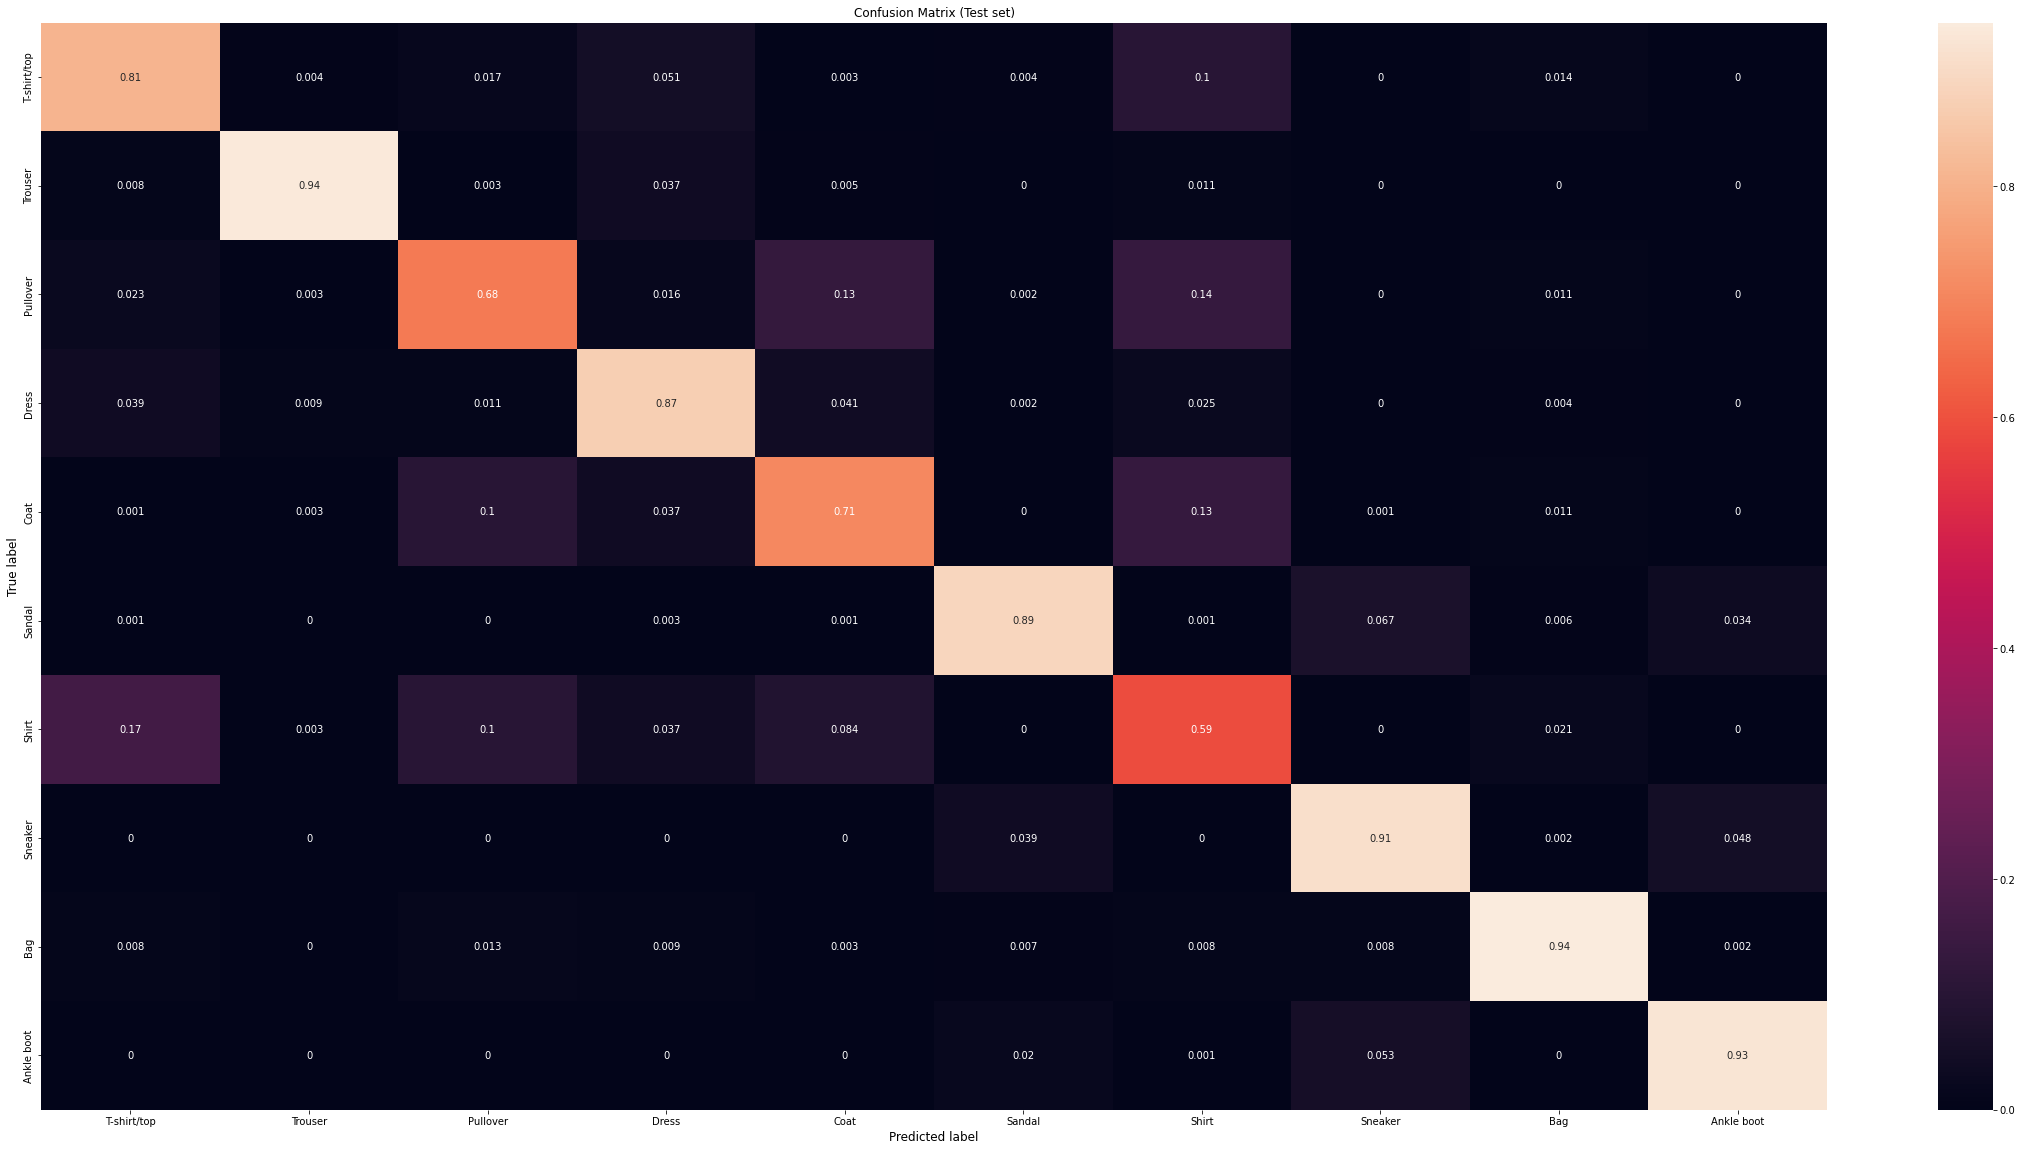

In [ ]:
import wandb
wandb.init(project="test_confusion", entity="sleya7110", name="confusion_matrix")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# accuracy = model.predict(testX,testY)
accuracy, test_predicted = model.predict(testX,testY)
bern_cnf_matrix_train = confusion_matrix(testY, test_predicted, normalize='true')
plt.figure(figsize=(40,20))
ax = sns.heatmap(bern_cnf_matrix_train, annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Test set)", size=12)
ax.set_xlabel("Predicted label", size=12)
ax.set_ylabel("True label", size=12)
plt.savefig("Test_confusionmatrix")
# Load the confusion matrix images
img1 = plt.imread("Test_confusionmatrix.png")

print("Test accuracy ",accuracy)
# Log images of the confusion matrices
wandb.log({"Confusion Matrix - Test set": wandb.Image(img1)})

